In [1]:
import mne
import numpy as np 
import matplotlib.pyplot as plt
import torch
import os
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torch.fft import rfft, irfft
from torch.nn.functional import normalize
from scipy.signal import welch
from scipy import signal
import math

NUM_CHANNELS = 1
SEQUENCE_LENGTH = 9760
LAMBDA_GP = 5

def compute_psd(data, fs, nperseg=256, noverlap=None):
    """
    Compute Power Spectral Density (PSD) using the Welch method.

    Parameters:
        data (array): EEG data array with shape (n_channels, n_samples).
        fs (float): Sampling frequency.
        nperseg (int): Length of each segment for PSD estimation.
        noverlap (int): Number of overlapping samples between segments.
    
    Returns:
        freqs (array): Frequency values.
        psd (array): Power Spectral Density values.
    """
    n_channels, n_samples = data.shape
    psd = np.zeros((n_channels, nperseg // 2 + 1))

    for ch_idx in range(n_channels):
        f, Pxx = plt.psd(data[ch_idx], Fs=fs, NFFT=256, noverlap=128, window=np.hanning(256), scale_by_freq=True)
        # Add a small epsilon to avoid zero values
        psd[ch_idx] = Pxx + 1e-10

    return f, psd

def average_across_arrays(generated_data):
    return generated_data.mean(dim=0)

# Set the sampling frequency
fs = 160.0

def weights_init(model):
    for m in model.modules():
      if isinstance(m, (nn.Conv1d)):
        nn.init.xavier_uniform_(m.weight.data, math.sqrt(2.0))

def gradient_penalty(D, real, fake):
    alpha = torch.rand((BATCH_SIZE, 1, 1)).repeat(1, NUM_CHANNELS, SEQUENCE_LENGTH)
    interpolated_seq = real * alpha + fake * (1 - alpha)

    # Calculate discriminator scores
    mixed_scores = D(interpolated_seq)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_seq,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

def plot_everything(generated_data, gen_err, critic_err):
    generated_data = generated_data.detach()
    
    # plotting generated data
    values = generated_data[0, 0, :]
    plt.plot(values.tolist())
    plt.show()

    # plotting PSD
    averaged_data = average_across_arrays(generated_data)
    freqs, psd = compute_psd(averaged_data, fs)
    plt.figure(figsize=(10, 6))  # Add this line to create a single figure
    for ch_idx in range(NUM_CHANNELS):
        plt.semilogy(freqs, psd[ch_idx], label=f'Channel {ch_idx + 1}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')
    plt.show()

    # plotting G vs D losses
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(gen_err,label="Generator")
    plt.plot(critic_err,label="Critic")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


# 83 batch size for eyes_open
# 76 batch size for eyes_closed

# resnet

Epoch 0: Critic error ([5.0]) Generator err ([0.025925740599632263])


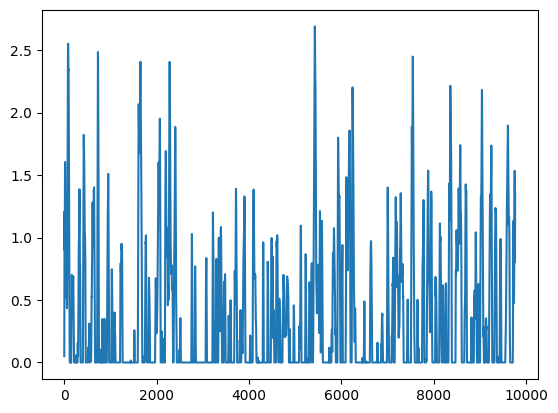

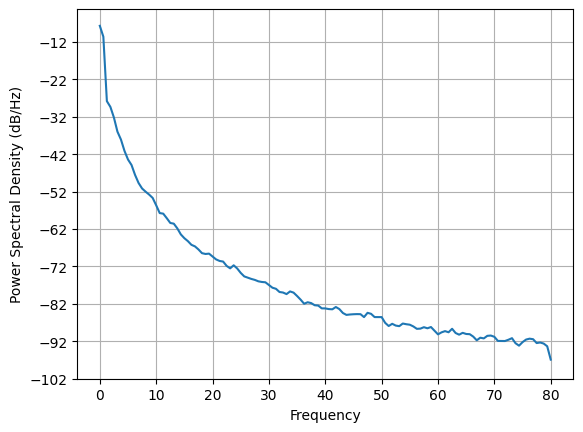

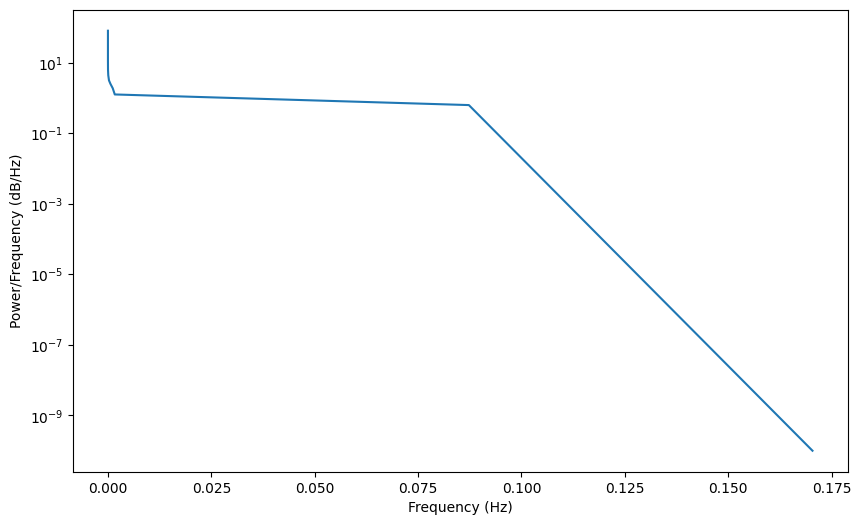

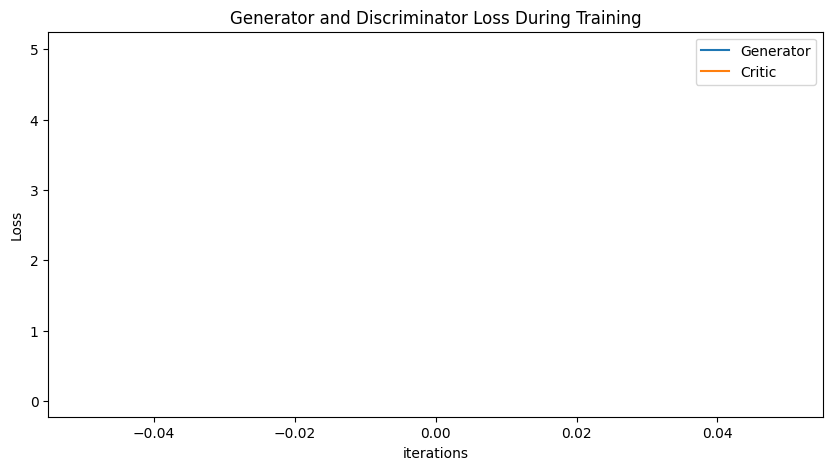

Epoch 10: Critic error ([5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]) Generator err ([0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263])


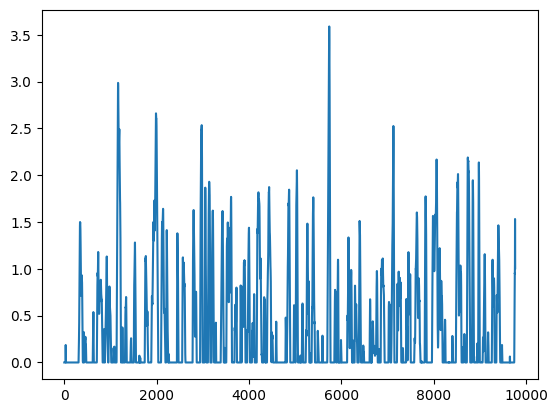

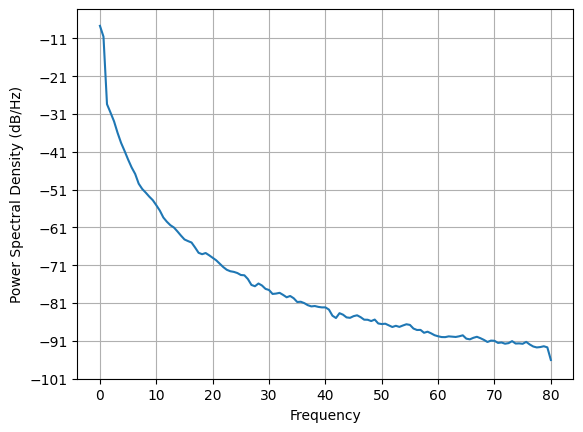

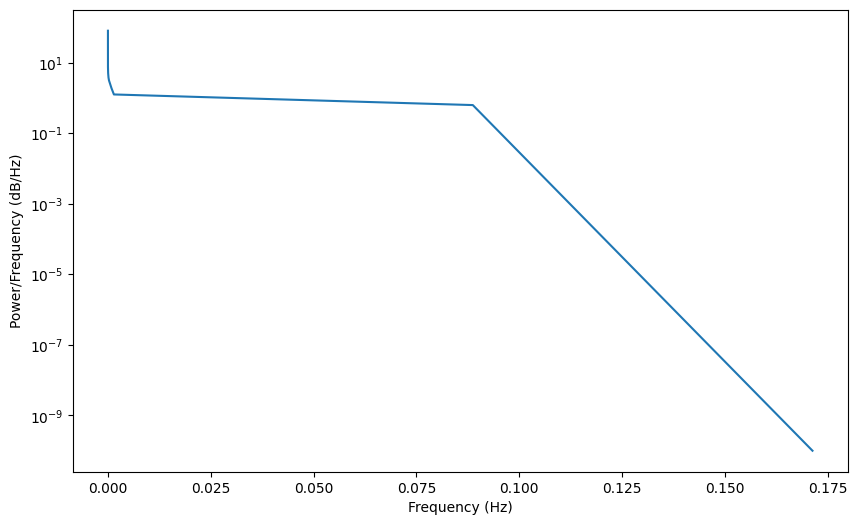

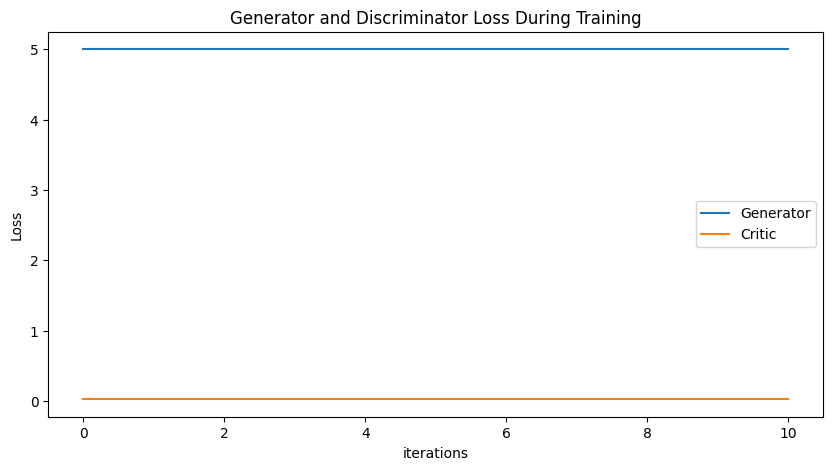

Epoch 20: Critic error ([5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]) Generator err ([0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263])


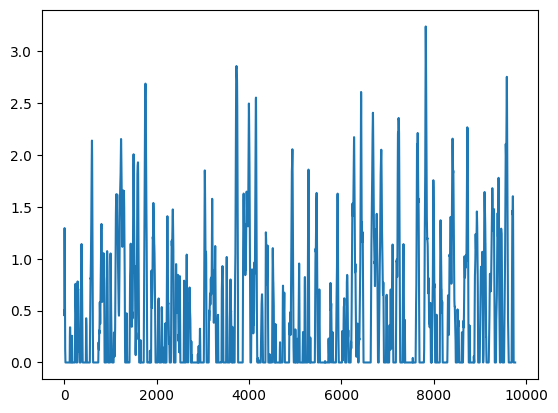

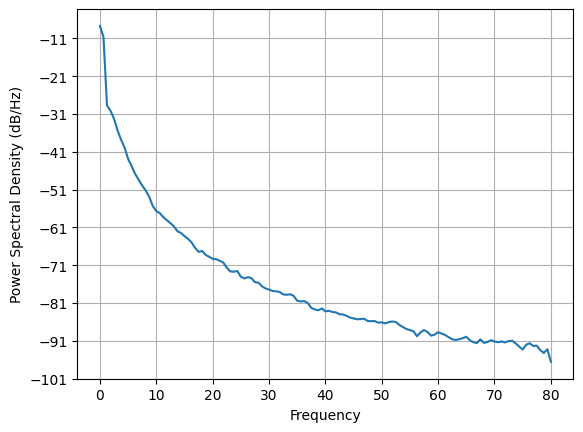

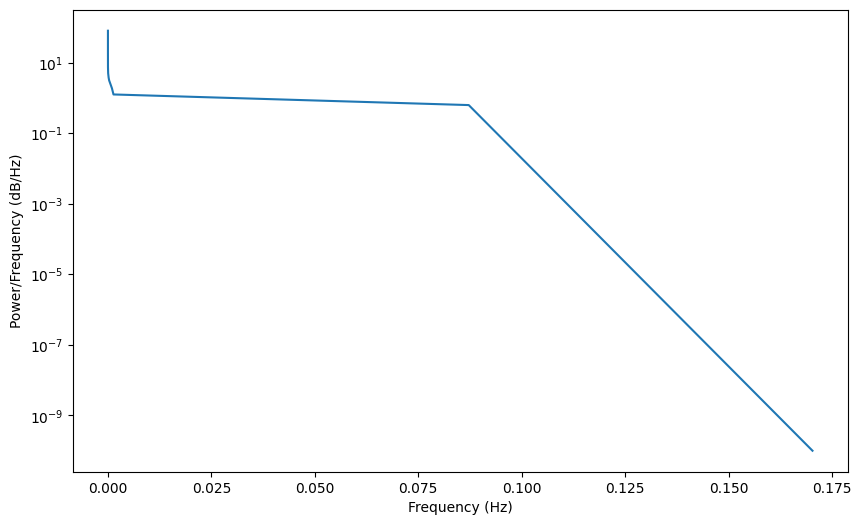

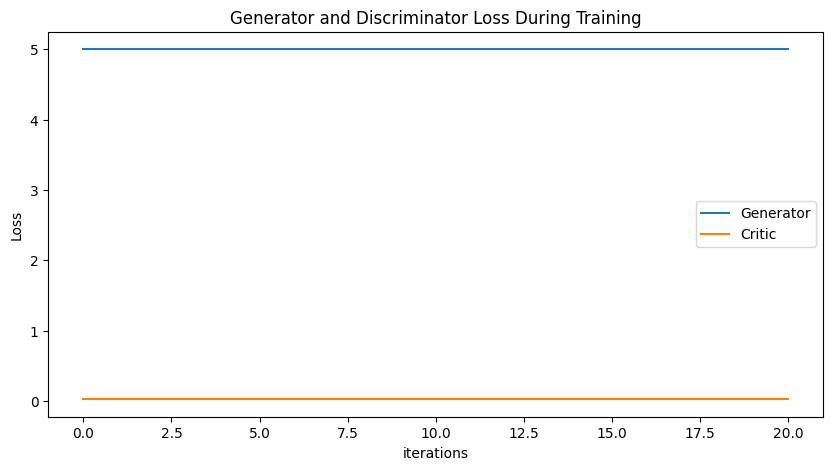

Epoch 30: Critic error ([5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]) Generator err ([0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263])


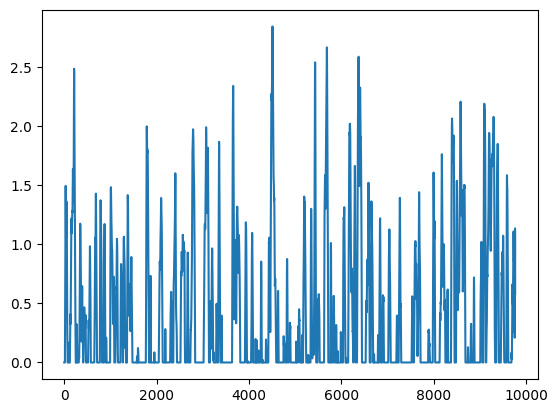

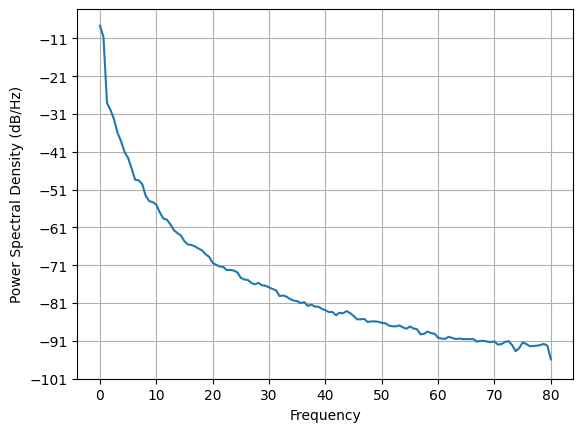

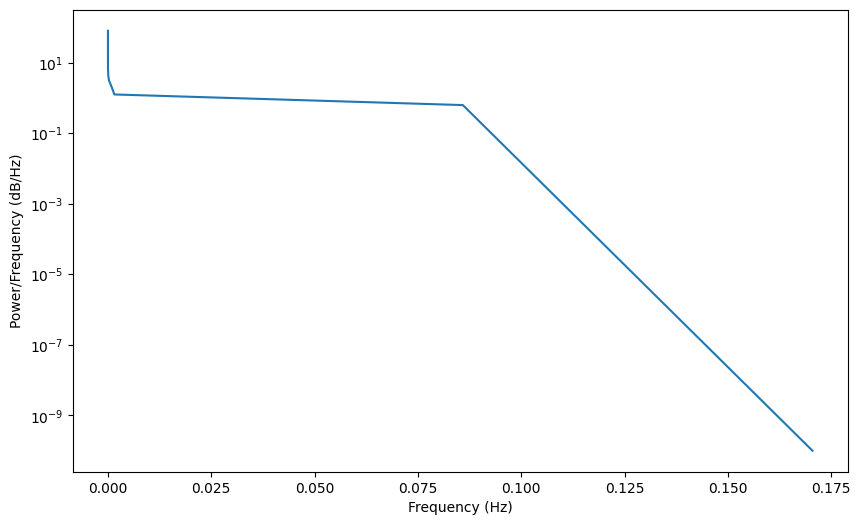

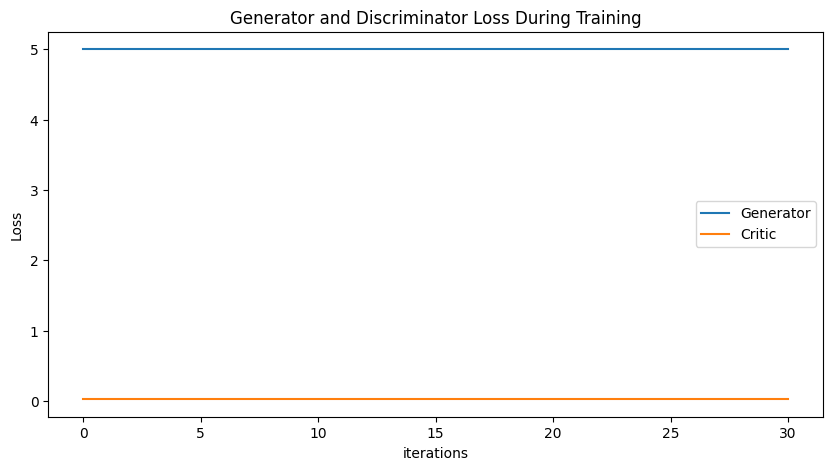

Epoch 40: Critic error ([5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]) Generator err ([0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025

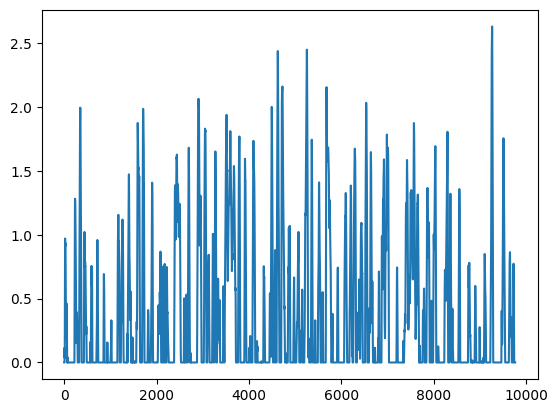

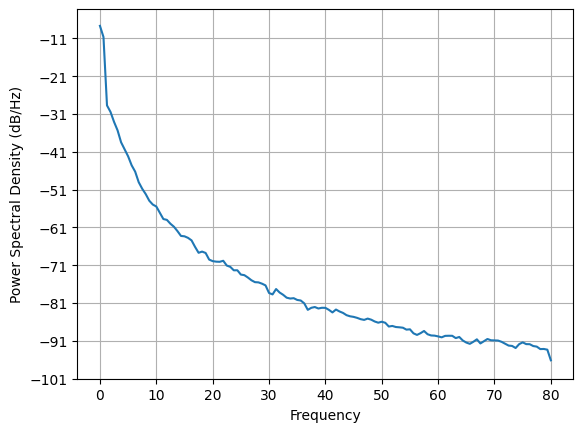

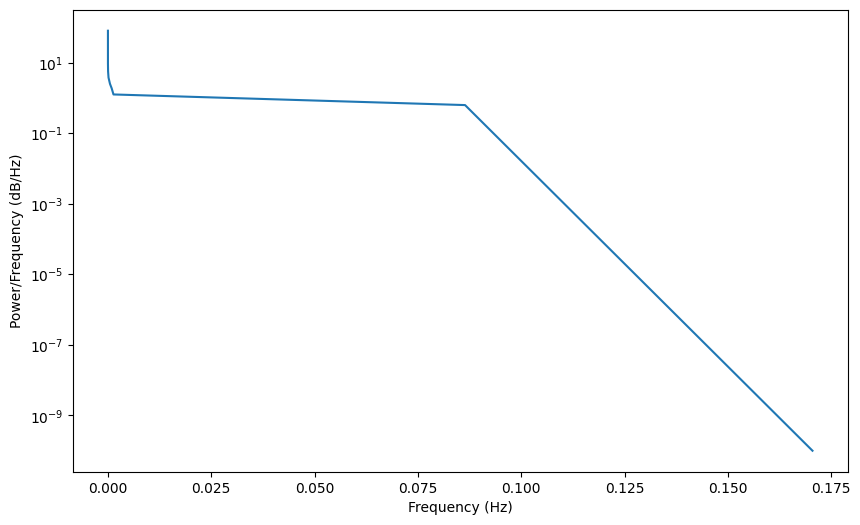

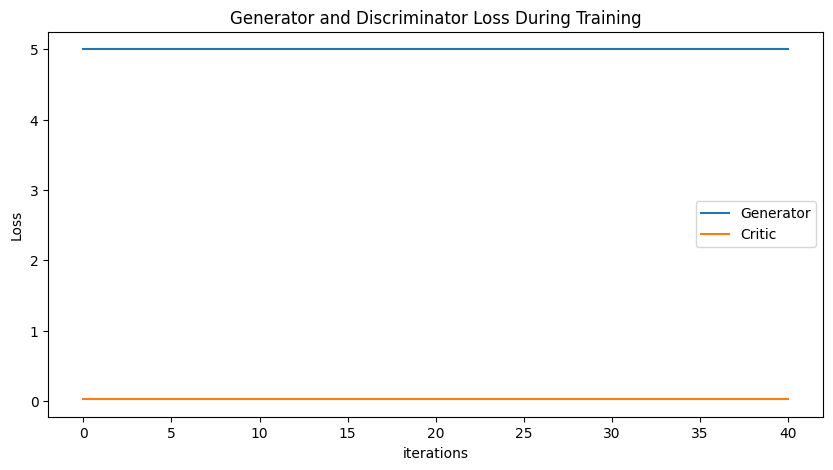

Epoch 50: Critic error ([5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]) Generator err ([0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263,

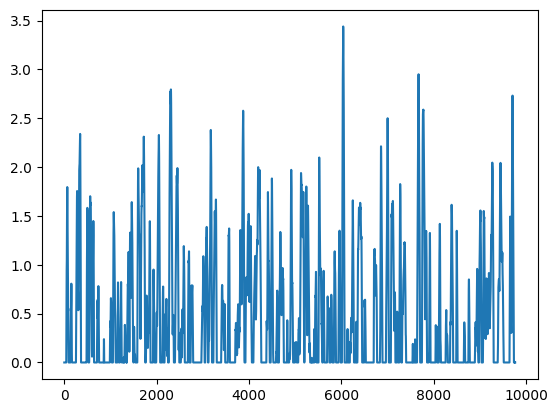

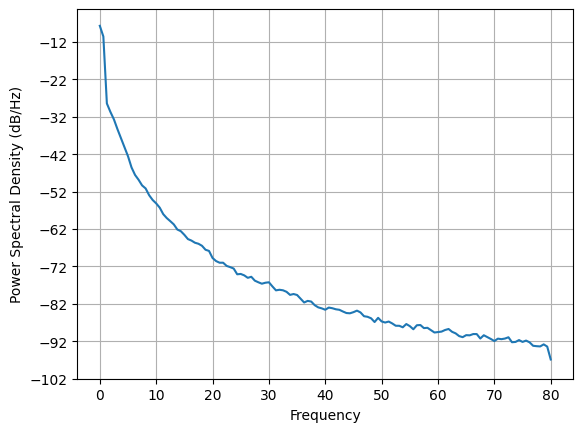

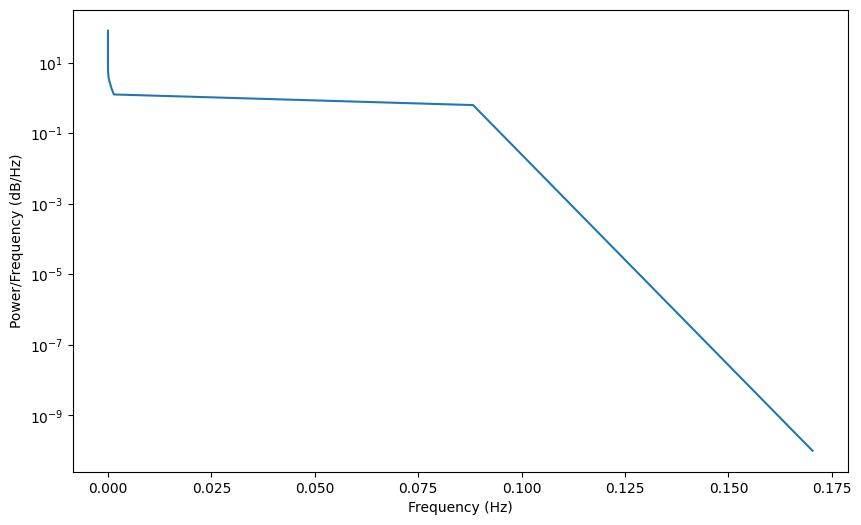

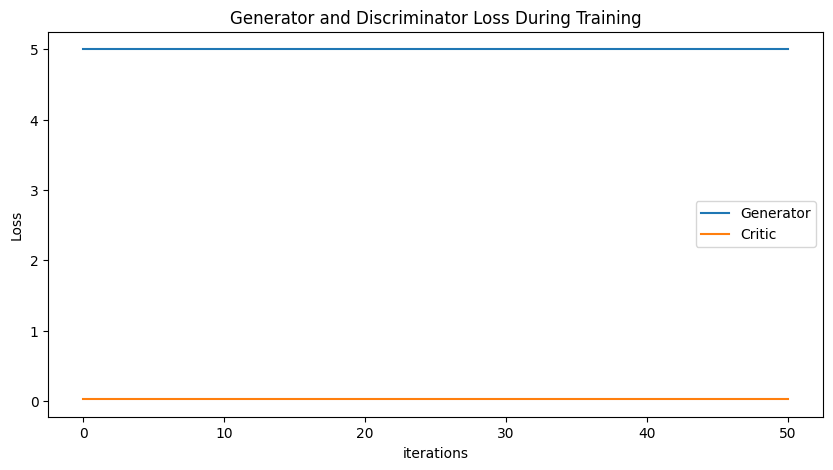

Epoch 60: Critic error ([5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]) Generator err ([0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.0259257405996

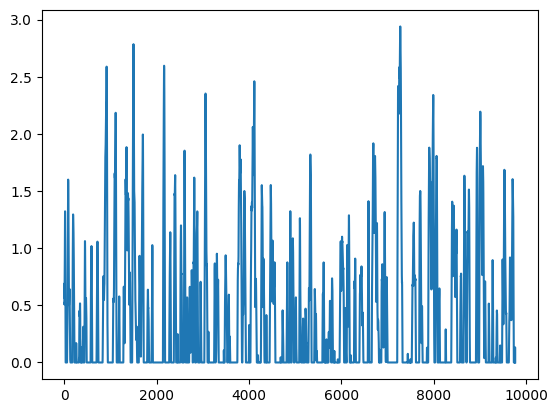

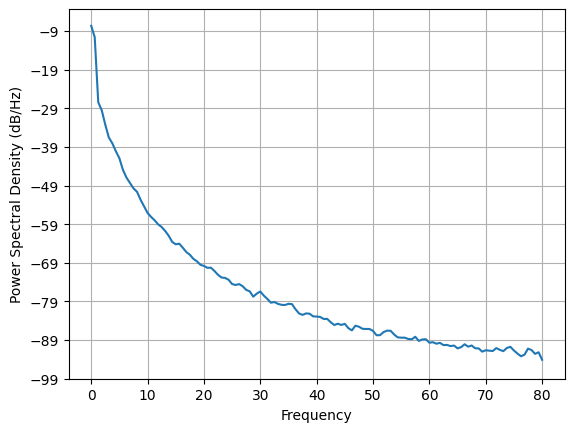

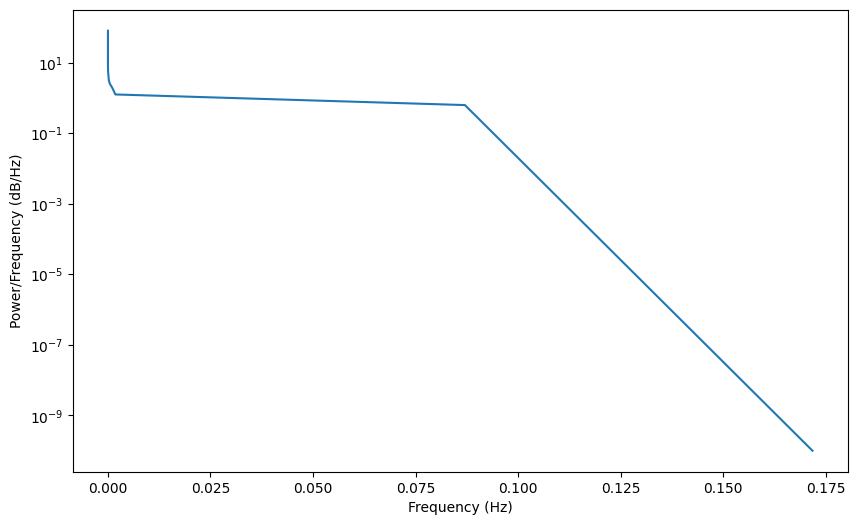

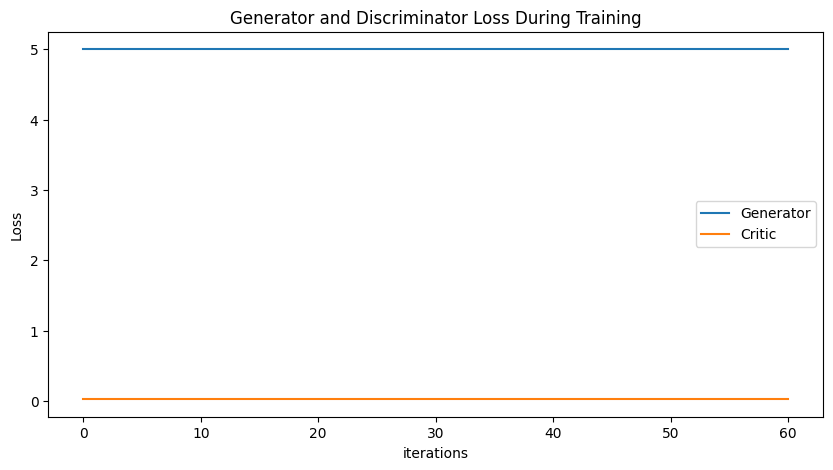

Epoch 70: Critic error ([5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]) Generator err ([0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.025925740599632263, 0.0259257

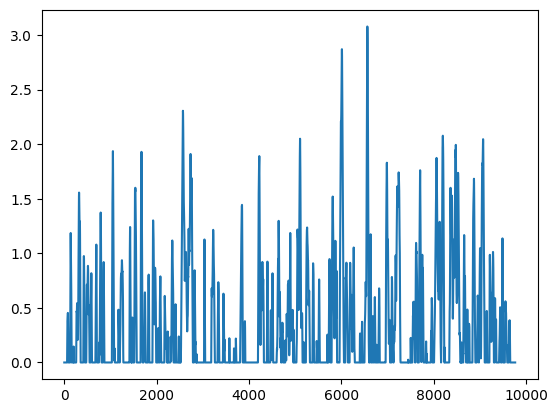

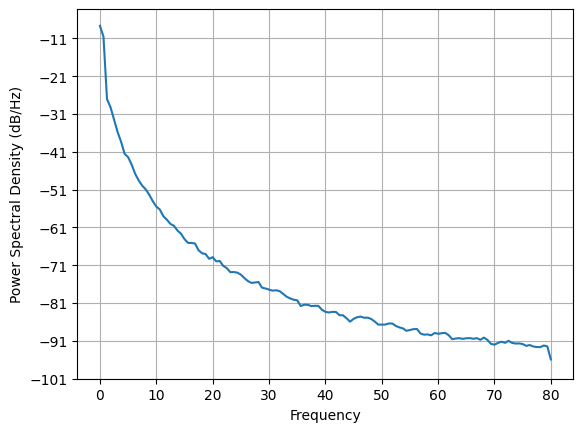

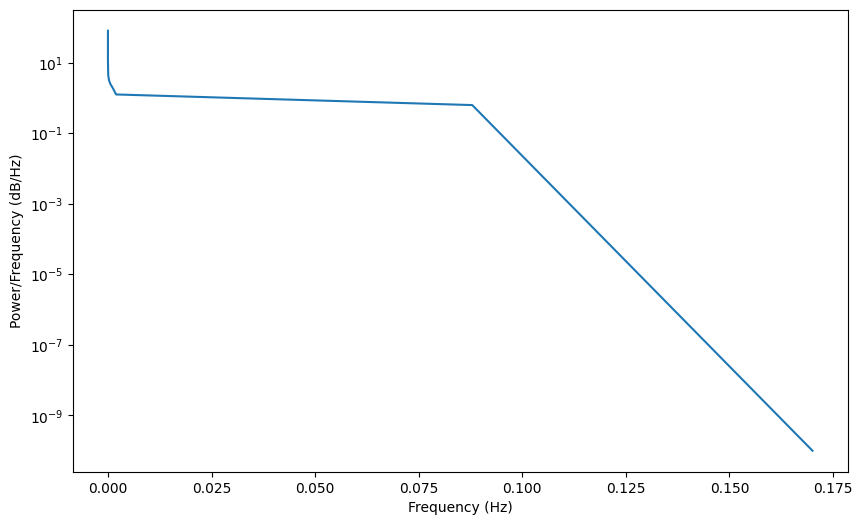

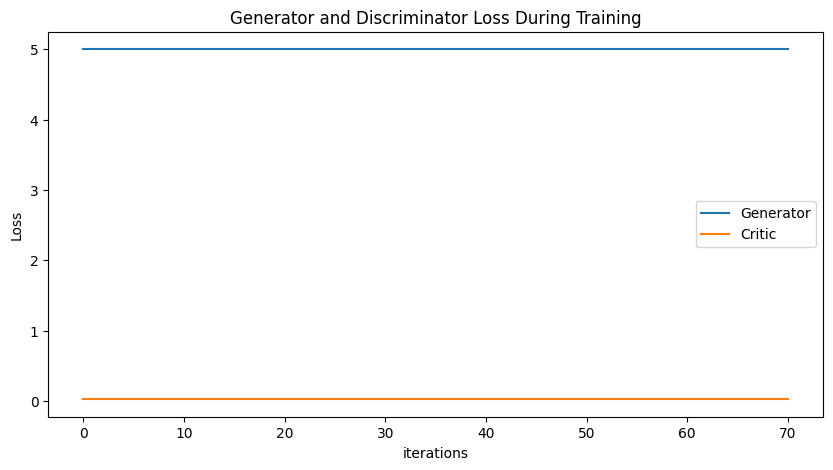

In [ ]:
NUM_EPOCHS = 300
PRINT_INTERVAL = 10
BATCH_SIZE = 76 
train_loader = DataLoader(
    TensorDataset(torch.tensor(np.load("training-closed-ch21.npy")).detach()), 
    batch_size=BATCH_SIZE, 
    shuffle=True
)
torch.autograd.set_detect_anomaly(False)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.res1_acti1 = nn.Sequential(nn.BatchNorm1d(200), nn.ReLU(inplace=False))
        self.res1_conv1 = nn.Conv1d(200, 200, kernel_size=9, stride=1, padding=4)
        self.res1_acti2 = nn.Sequential(nn.BatchNorm1d(200), nn.ReLU(inplace=False))
        self.res1_conv2 = nn.Conv1d(200, 200, kernel_size=9, stride=1, padding=4)

        self.res2_acti1 = nn.Sequential(nn.BatchNorm1d(200), nn.ReLU(inplace=False))
        self.res2_conv1 = nn.Conv1d(200, 200, kernel_size=9, stride=1, padding=4)
        self.res2_acti2 = nn.Sequential(nn.BatchNorm1d(200), nn.ReLU(inplace=False))
        self.res2_conv2 = nn.Conv1d(200, 200, kernel_size=9, stride=1, padding=4)

        self.res3_acti1 = nn.Sequential(nn.BatchNorm1d(200), nn.ReLU(inplace=False))
        self.res3_conv1 = nn.Conv1d(200, 200, kernel_size=9, stride=1, padding=4)
        self.res3_acti2 = nn.Sequential(nn.BatchNorm1d(200), nn.ReLU(inplace=False))
        self.res3_conv2 = nn.Conv1d(200, 200, kernel_size=9, stride=1, padding=4)

        self.res4_acti1 = nn.Sequential(nn.BatchNorm1d(200), nn.ReLU(inplace=False))
        self.res4_conv1 = nn.Conv1d(200, 200, kernel_size=9, stride=1, padding=4)
        self.res4_acti2 = nn.Sequential(nn.BatchNorm1d(200), nn.ReLU(inplace=False))
        self.res4_conv2 = nn.Conv1d(200, 200, kernel_size=9, stride=1, padding=4)

        self.res5_acti1 = nn.Sequential(nn.BatchNorm1d(200), nn.ReLU(inplace=False))
        self.res5_conv1 = nn.Conv1d(200, 200, kernel_size=9, stride=1, padding=4)
        self.res5_acti2 = nn.Sequential(nn.BatchNorm1d(200), nn.ReLU(inplace=False))
        self.res5_conv2 = nn.Conv1d(200, 1, kernel_size=9, stride=1, padding=4)

        self.batch = nn.BatchNorm1d(1)
        self.ReLU = nn.ReLU(True)
        self.identity_transform = nn.Conv1d(200, 1, kernel_size=1)

    def forward(self, x):        
        identity = x
        x = self.res1_acti1(x)
        x = self.res1_conv1(F.interpolate(x, scale_factor=2, mode='linear', align_corners=False))
        x = self.res1_acti2(x)
        x = self.res1_conv2(x)
        identity = F.interpolate(identity, scale_factor=2, mode='linear', align_corners=False)
        x = torch.add(x, identity)
        
        identity = x
        x = self.res2_acti1(x)
        x = self.res2_conv1(F.interpolate(x, scale_factor=2, mode='linear', align_corners=False))
        x = self.res2_acti2(x)
        x = self.res2_conv2(x)
        identity = F.interpolate(identity, scale_factor=2, mode='linear', align_corners=False)
        x = torch.add(x, identity)
        
        identity = x
        x = self.res3_acti1(x)
        x = self.res3_conv1(F.interpolate(x, scale_factor=2, mode='linear', align_corners=False))
        x = self.res3_acti2(x)
        x = self.res3_conv2(x)
        identity = F.interpolate(identity, scale_factor=2, mode='linear', align_corners=False)
        x = torch.add(x, identity)
        
        identity = x
        x = self.res4_acti1(x)
        x = self.res4_conv1(F.interpolate(x, scale_factor=2, mode='linear', align_corners=False))
        x = self.res4_acti2(x)
        x = self.res4_conv2(x)
        identity = F.interpolate(identity, scale_factor=2, mode='linear', align_corners=False)
        x = torch.add(x, identity)
        
        identity = x
        x = self.res5_acti1(x)
        x = self.res5_conv1(F.interpolate(x, scale_factor=2, mode='linear', align_corners=False))
        x = self.res5_acti2(x)
        x = self.res5_conv2(x)
        identity = F.interpolate(identity, scale_factor=2, mode='linear', align_corners=False)
        identity = self.identity_transform(identity)
        x = torch.add(x, identity)
        
        x = self.batch(x)
        x = self.ReLU(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.res1_acti1 = nn.ReLU(inplace=False)
        self.res1_conv1 = nn.Conv1d(1, 200, kernel_size=9, stride=1, padding=4)
        self.res1_acti2 = nn.ReLU(inplace=False)
        self.res1_conv2 = nn.Conv1d(200, 200, kernel_size=9, stride=1, padding=4)

        self.res2_acti1 = nn.ReLU(inplace=False)
        self.res2_conv1 = nn.Conv1d(200, 200, kernel_size=9, stride=1, padding=4)
        self.res2_acti2 = nn.ReLU(inplace=False)
        self.res2_conv2 = nn.Conv1d(200, 200, kernel_size=9, stride=1, padding=4)

        self.res3_acti1 = nn.ReLU(inplace=False)
        self.res3_conv1 = nn.Conv1d(200, 200, kernel_size=9, stride=1, padding=4)
        self.res3_acti2 = nn.ReLU(inplace=False)
        self.res3_conv2 = nn.Conv1d(200, 200, kernel_size=9, stride=1, padding=4)

        self.res4_acti1 = nn.ReLU(inplace=False)
        self.res4_conv1 = nn.Conv1d(200, 200, kernel_size=9, stride=1, padding=4)
        self.res4_acti2 = nn.ReLU(inplace=False)
        self.res4_conv2 = nn.Conv1d(200, 200, kernel_size=9, stride=1, padding=4)

        self.res5_acti1 = nn.ReLU(inplace=False)
        self.res5_conv1 = nn.Conv1d(200, 200, kernel_size=9, stride=1, padding=4)
        self.res5_acti2 = nn.ReLU(inplace=False)
        self.res5_conv2 = nn.Conv1d(200, 200, kernel_size=9, stride=1, padding=4)

        self.res6_acti1 = nn.ReLU(inplace=False)
        self.res6_conv1 = nn.Conv1d(200, 200, kernel_size=9, stride=1, padding=4)
        self.res6_acti2 = nn.ReLU(inplace=False)
        self.res6_conv2 = nn.Conv1d(200, 1, kernel_size=9, stride=1, padding=4)

        self.ReLU = nn.ReLU(inplace=False)
        self.end = nn.Linear(152, 1)
        self.identity_transform = nn.Conv1d(200, 1, kernel_size=1)

    def forward(self, x):
        x = x.float()
        identity = x
        x = self.res1_acti1(x)
        x = self.res1_conv1(x)
        x = self.res1_acti2(x)
        x = self.res1_conv2(x)
        x = F.avg_pool1d(x, 2)
        identity = F.avg_pool1d(identity, 2)
        x = torch.add(x, identity)
        
        identity = x
        x = self.res2_acti1(x)
        x = self.res2_conv1(x)
        x = self.res2_acti2(x)
        x = self.res2_conv2(x)
        x = F.avg_pool1d(x, 2)
        identity = F.avg_pool1d(identity, 2)
        x = torch.add(x, identity)
        
        identity = x
        x = self.res3_acti1(x)
        x = self.res3_conv1(x)
        x = self.res3_acti2(x)
        x = self.res3_conv2(x)
        x = F.avg_pool1d(x, 2)
        identity = F.avg_pool1d(identity, 2)
        x = torch.add(x, identity)
        
        identity = x
        x = self.res4_acti1(x)
        x = self.res4_conv1(x)
        x = self.res4_acti2(x)
        x = self.res4_conv2(x)
        x = F.avg_pool1d(x, 2)
        identity = F.avg_pool1d(identity, 2)
        x = torch.add(x, identity)
        
        identity = x
        x = self.res5_acti1(x)
        x = self.res5_conv1(x)
        x = self.res5_acti2(x)
        x = self.res5_conv2(x)
        x = F.avg_pool1d(x, 2)
        identity = F.avg_pool1d(identity, 2)
        x = torch.add(x, identity)
        
        identity = x
        x = self.res6_acti1(x)
        x = self.res6_conv1(x)
        x = self.res6_acti2(x)
        x = self.res6_conv2(x)
        x = F.avg_pool1d(x, 2)
        identity = F.avg_pool1d(identity, 2)
        identity = self.identity_transform(identity)
        x = torch.add(x, identity)
        
        x = self.ReLU(x)
        x = self.end(x)
        return x
    
def train():
    critic_err, gen_err = [], []
    G, D = Generator(), Discriminator()
    weights_init(G)
    weights_init(D)
    critic_optimizer = optim.RMSprop(D.parameters(), lr=1e-5)
    gen_optimizer = optim.RMSprop(G.parameters(), lr=1e-5)

    for epoch in range(NUM_EPOCHS):
        (real, ) = next(iter(train_loader))
        real.requires_grad = True

        for _ in range(5):
            fake = G(torch.randn(BATCH_SIZE, 200, 305))
            critic_real = D(real).reshape(-1)
            critic_fake = D(fake).reshape(-1)
            D.zero_grad()            
            loss_critic = -torch.mean(critic_real) + torch.mean(critic_fake) + (gradient_penalty(D, real, fake) * LAMBDA_GP)
            loss_critic.backward()
            critic_optimizer.step()  

        fake = G(torch.randn(BATCH_SIZE, 200, 305))
        gen_fake = D(fake).reshape(-1)
        G.zero_grad()
        loss_gen = -torch.mean(gen_fake)
        loss_gen.backward()
        gen_optimizer.step()
        
        critic_err.append(loss_critic.item())
        gen_err.append(loss_gen.item())

        if epoch % PRINT_INTERVAL == 0:
            print("Epoch %s: Critic error (%s) Generator err (%s)" % (epoch, critic_err, gen_err))
            plot_everything(fake, critic_err, gen_err)

    return critic_err, gen_err, fake, D, G

critic_err, gen_err, generated, disc, gen = train()

torch.save(gen, 'generator-v14.pt')
torch.save(disc, 'discriminator-v14.pt')
np.save('closed-v14.npy', generated.detach())
plot_everything(generated, gen_err, critic_err)
generated_data_closed = None